In [2]:
!nvidia-smi

Fri Jul 12 11:42:28 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.44                 Driver Version: 552.44         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   40C    P0             11W /   80W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
import pandas as pd
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data


import medmnist
from medmnist import INFO, Evaluator

c:\Users\Dheeraj\AppData\Local\NVIDIA\MiniConda\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from MedViT import MedViT_small as tiny
from MedViT import MedViT_base as base
from MedViT import MedViT_large as large

In [5]:
class LGGSegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_paths = []
        self.mask_paths = []

        # Load all image and mask paths
        for case in os.listdir(root_dir):
            case_dir = os.path.join(root_dir, case)
            if os.path.isdir(case_dir):
                for file in os.listdir(case_dir):
                    if file.endswith('.tif') and not file.endswith('_mask.tif'):
                        self.image_paths.append(os.path.join(case_dir, file))
                        mask_path = os.path.join(case_dir, file.replace('.tif', '_mask.tif'))
                        self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Mask is a single-channel image

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask


In [6]:
# Define transformations for images and masks
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [7]:
from sklearn.model_selection import train_test_split

# Load the dataset
root_dir = 'Data\lgg-mri-segmentation'
dataset = LGGSegmentationDataset(root_dir, transform=image_transform, target_transform=mask_transform)


# Split dataset into train, validation, and test sets
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(val_indices, test_size=0.5, random_state=42)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [8]:
# Load and modify the model
pretrained_model = tiny()
checkpoint = torch.load('MedViT_small_im1k.pth')
pretrained_model.load_state_dict(checkpoint['model'])

initialize_weights...


<All keys matched successfully>

In [10]:
class MedViT_Segmentation(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super(MedViT_Segmentation, self).__init__()
        self.encoder = nn.Sequential(*list(pretrained_model.children())[:-2])
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),  # 56x56 -> 112x112
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),   # 112x112 -> 224x224
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),   # 224x224 -> 448x448
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),    # 448x448 -> 896x896
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),     # 896x896 -> 1792x1792
            nn.ReLU(),
            nn.Conv2d(32, num_classes, kernel_size=1)  # 1792x1792 -> 224x224
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [11]:
num_classes = 1  # Binary segmentation
model = MedViT_Segmentation(pretrained_model, num_classes).cuda()

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [37]:
import torch
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)  # Apply sigmoid to the inputs
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

class BCEWithLogitsDiceLoss(nn.Module):
    def __init__(self):
        super(BCEWithLogitsDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        return bce_loss + dice_loss

# Define loss function and optimizer
criterion = BCEWithLogitsDiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [38]:
model

MedViT_Segmentation(
  (encoder): Sequential(
    (0): Sequential(
      (0): ConvBNReLU(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (1): ConvBNReLU(
        (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (2): ConvBNReLU(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (3): ConvBNReLU(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=

In [39]:
import time
import torch

# Directory where you want to save the model
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)

# Training loop
num_epochs = 10
best_val_loss = float('inf')  # Initialize best validation loss to infinity

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    
    model.train()
    running_loss = 0.0
    num_batches = len(train_loader)
    batch_durations = []

    for batch_idx, (images, masks) in enumerate(train_loader):
        batch_start_time = time.time()

        images, masks = images.cuda(), masks.cuda()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # Calculate batch duration and update list
        batch_duration = time.time() - batch_start_time
        batch_durations.append(batch_duration)
        
        # Estimate remaining time for the epoch
        avg_batch_duration = sum(batch_durations) / len(batch_durations)
        remaining_batches = num_batches - (batch_idx + 1)
        estimated_remaining_time = remaining_batches * avg_batch_duration

        # Print progress and estimated remaining time
        print(f'Batch [{batch_idx + 1}/{num_batches}], '
              f'Loss: {loss.item():.3f}, '
              f'Estimated remaining time: {estimated_remaining_time:.2f} second', end='\r')

    avg_train_loss = running_loss / num_batches
    print(f'\nEpoch [{epoch + 1}/{num_epochs}], Loss: {avg_train_loss:.4f}')
    
    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.cuda(), masks.cuda()
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    print(f'Validation Loss: {avg_val_loss:.4f}')
    
    # Save model checkpoint if current validation loss is the best we've seen so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        checkpoint_path = f'best_model_epoch_{epoch + 1}.pth'
        torch.save(model.state_dict(), os.path.join(save_dir, checkpoint_path))  # Save the state dictionary of the model_path)
        print(f'Saved best model checkpoint at {checkpoint_path}')
    
    epoch_duration = time.time() - epoch_start_time
    print(f'Epoch duration: {epoch_duration:.2f} seconds')

print('Training complete.')


Epoch [1/10]
Batch [197/197], Loss: 0.188, Estimated remaining time: 0.00 secondss
Epoch [1/10], Loss: 0.1549
Validation Loss: 0.2336
Saved best model checkpoint at best_model_epoch_1.pth
Epoch duration: 120.01 seconds
Epoch [2/10]
Batch [197/197], Loss: 0.143, Estimated remaining time: 0.00 secondss
Epoch [2/10], Loss: 0.1696
Validation Loss: 0.2283
Saved best model checkpoint at best_model_epoch_2.pth
Epoch duration: 85.60 seconds
Epoch [3/10]
Batch [197/197], Loss: 0.129, Estimated remaining time: 0.00 secondss
Epoch [3/10], Loss: 0.1736
Validation Loss: 0.2350
Epoch duration: 90.49 seconds
Epoch [4/10]
Batch [197/197], Loss: 0.173, Estimated remaining time: 0.00 secondss
Epoch [4/10], Loss: 0.1409
Validation Loss: 0.2054
Saved best model checkpoint at best_model_epoch_4.pth
Epoch duration: 79.95 seconds
Epoch [5/10]
Batch [197/197], Loss: 0.051, Estimated remaining time: 0.00 secondss
Epoch [5/10], Loss: 0.1343
Validation Loss: 0.2155
Epoch duration: 109.10 seconds
Epoch [6/10]
Bat

In [40]:
# load the best model
model_path = 'saved_models/best_model_epoch_6.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [41]:
def accuracy(preds, masks):
    preds = (preds > 0.9).float()
    correct = (preds == masks).float().sum()
    total = torch.numel(preds)
    return correct / total

acc = accuracy(torch.sigmoid(outputs), masks)
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.9961


In [42]:
def dice_coefficient(preds, targets, threshold=0.5):
    #preds = torch.sigmoid(preds) > threshold  # Apply sigmoid and threshold
    preds = preds.float()
    targets = targets.float()
    
    intersection = (preds * targets).sum((1, 2, 3))
    union = preds.sum((1, 2, 3)) + targets.sum((1, 2, 3))
    
    dice = (2. * intersection + 1e-6) / (union + 1e-6)
    return dice.mean()


dice = dice_coefficient(torch.sigmoid(outputs), masks)
print(f'Dice Coefficient: {dice:.4f}')

Dice Coefficient: 0.1942


In [43]:
def iou(preds, masks, threshold=0.5):
    preds = (preds > threshold).int()
    masks = masks.int()
    intersection = (preds & masks).float().sum((1, 2, 3))
    union = (preds | masks).float().sum((1, 2, 3))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()


In [44]:
# Evaluate the model
model.eval()
test_loss = 0.0
test_iou = 0.0
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.cuda(), masks.cuda()
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()
        test_iou += iou(torch.sigmoid(outputs), masks).item()
test_loss /= len(test_loader)
test_iou /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}')

Test Loss: 0.1677, Test IoU: 0.8612


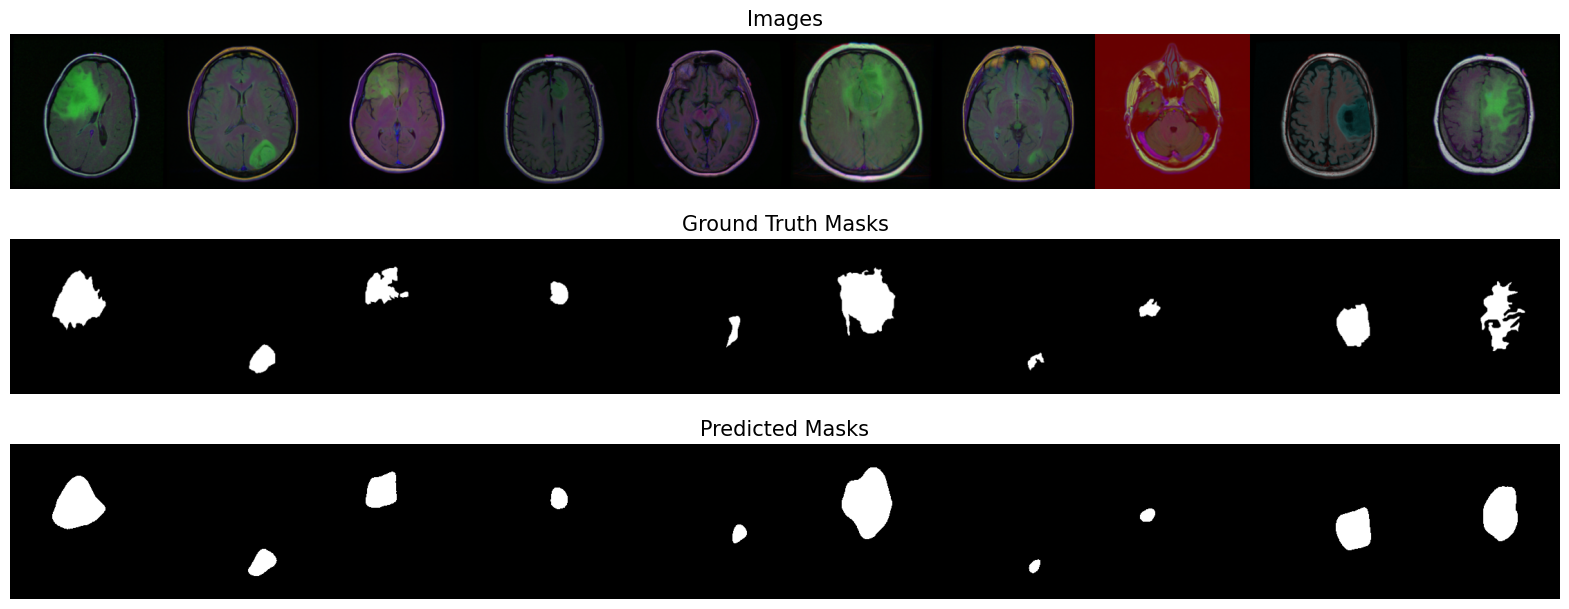

In [58]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2

# Define the unnormalization function
def unnormalize(img, mean, std):
    img = img.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

# Function to overlay masks on the original image
def overlay_masks(image, mask, alpha=0.5, color=(0, 1, 0)):
    mask = mask.squeeze().cpu().numpy()
    image = image.permute(1, 2, 0).cpu().numpy()
    color_mask = np.zeros_like(image)
    color_mask[mask > 0] = color
    overlayed_image = image * (1 - alpha) + color_mask * alpha
    return overlayed_image

# Function to visualize the results
def visualize_results(model, test_loader, device, mean, std, threshold=0.5):
    model.eval()
    positive_diagnosis_samples = []

    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
            preds = probs > threshold  # Convert probabilities to binary masks

            # Collect samples with positive diagnosis
            for idx in range(len(images)):
                if torch.sum(masks[idx]) > 0:  # Check for positive diagnosis
                    img = unnormalize(images[idx].cpu(), mean, std).permute(1, 2, 0).numpy()
                    gt_mask = masks[idx].cpu().squeeze().numpy()
                    pred_mask = preds[idx].cpu().squeeze().numpy().astype(np.uint8)  # Convert to uint8
                    positive_diagnosis_samples.append((img, gt_mask, pred_mask))
            
            if len(positive_diagnosis_samples) >= 5:
                break

    # Select up to 10 positive diagnosis samples
    positive_diagnosis_samples = positive_diagnosis_samples[:10]
    
    # Prepare arrays for visualization
    sample_imgs = [cv2.resize(img, (224, 224)) for img, _, _ in positive_diagnosis_samples]
    sample_gt_masks = [cv2.resize(gt_mask, (224, 224)) for _, gt_mask, _ in positive_diagnosis_samples]
    sample_pred_masks = [cv2.resize(pred_mask, (224, 224)) for _, _, pred_mask in positive_diagnosis_samples]

    sample_imgs_arr = np.hstack(sample_imgs)
    sample_gt_masks_arr = np.hstack(sample_gt_masks)
    sample_pred_masks_arr = np.hstack(sample_pred_masks)

    # Plot
    fig = plt.figure(figsize=(20, 15))
    
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(3, 1),  # creates 3x1 grid of axes
                    axes_pad=0.5,  # pad between axes in inch.
                    )

    titles = ["Images", "Ground Truth Masks", "Predicted Masks"]
    arrays = [sample_imgs_arr, sample_gt_masks_arr, sample_pred_masks_arr]

    for ax, arr, title in zip(grid, arrays, titles):
        ax.imshow(arr, cmap='gray' if 'Masks' in title else None)
        ax.set_title(title, fontsize=15)
        ax.axis("off")
        ax.grid(False)  # Turn off grid lines for better clarity

    

    plt.show()


# Assuming you have a test_loader and a trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Mean and std used in normalization (these should be the same as used during training)
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# Visualize the results with positive diagnosis samples
visualize_results(model, test_loader, device, mean, std, threshold=0.5)


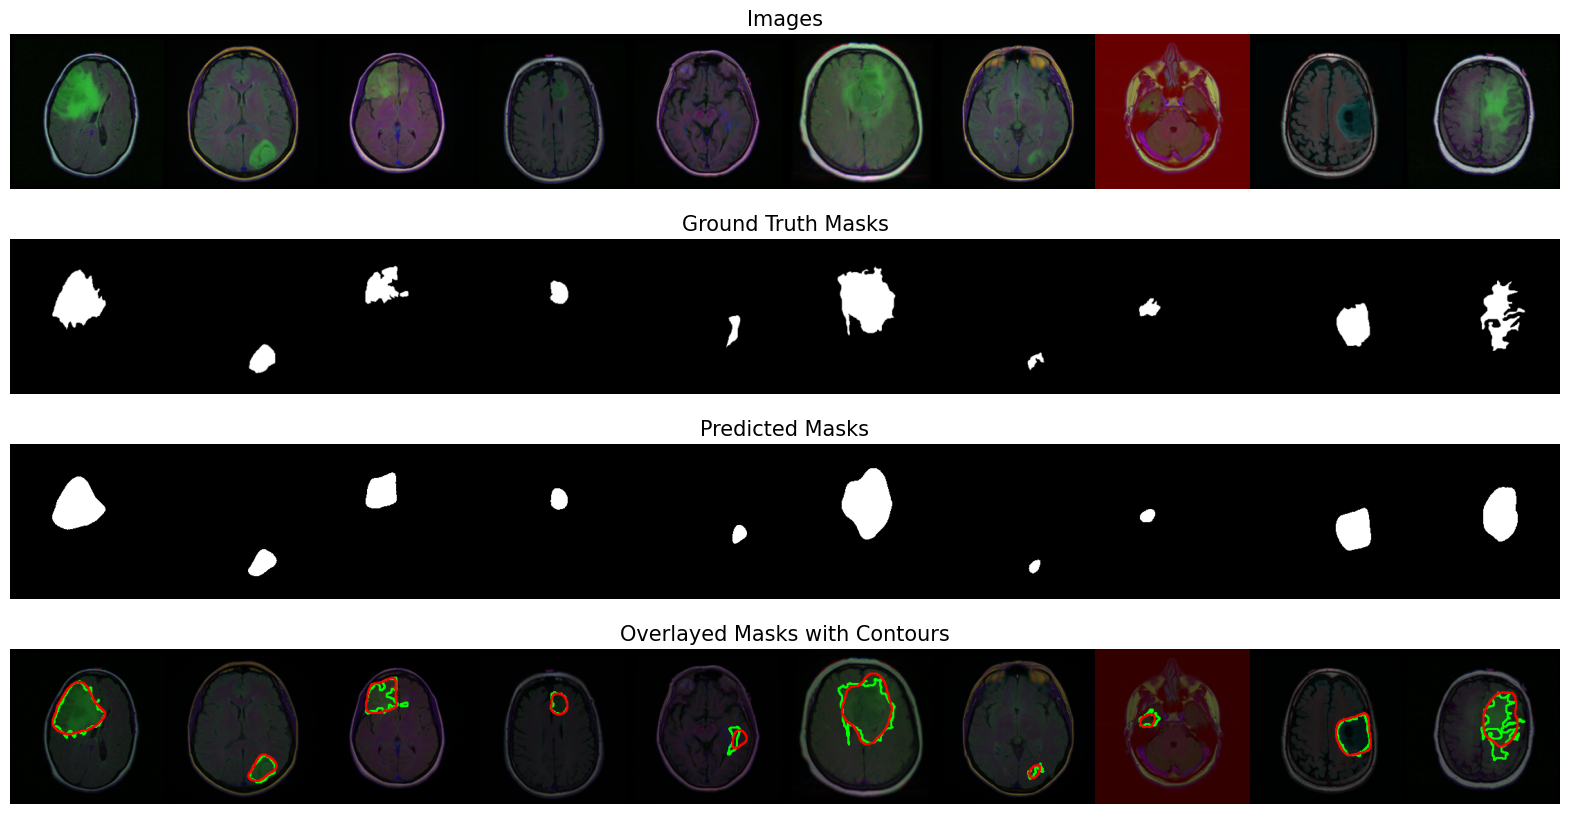

In [64]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2

# Define the unnormalization function
def unnormalize(img, mean, std):
    img = img.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

# Function to overlay masks on the original image
def overlay_masks(image, mask, alpha=0.5, color=(0, 255, 0)):
    mask = mask.squeeze().cpu().numpy()
    image = image.permute(1, 2, 0).cpu().numpy()
    color_mask = np.zeros_like(image)
    color_mask[mask > 0] = color
    overlayed_image = image * (1 - alpha) + color_mask * alpha
    return overlayed_image

# Function to highlight contours for both ground truth and predicted masks
def highlight_contours(image, gt_mask, pred_mask, gt_color=(0, 255, 0), pred_color=(255, 0, 0)):
    gt_mask = gt_mask.astype(np.uint8)
    pred_mask = pred_mask.astype(np.uint8)
    image = (image * 255).astype(np.uint8)
    image = np.ascontiguousarray(image)  # Ensure the image is contiguous
    
    gt_contours, _ = cv2.findContours(gt_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pred_contours, _ = cv2.findContours(pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    cv2.drawContours(image, gt_contours, -1, gt_color, 2)
    cv2.drawContours(image, pred_contours, -1, pred_color, 2)
    
    return image

# Function to visualize the results
def visualize_results(model, test_loader, device, mean, std, threshold=0.5):
    model.eval()
    positive_diagnosis_samples = []

    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
            preds = probs > threshold  # Convert probabilities to binary masks

            # Collect samples with positive diagnosis
            for idx in range(len(images)):
                if torch.sum(masks[idx]) > 0:  # Check for positive diagnosis
                    img = unnormalize(images[idx].cpu(), mean, std).permute(1, 2, 0).numpy()
                    gt_mask = masks[idx].cpu().squeeze().numpy()
                    pred_mask = preds[idx].cpu().squeeze().numpy().astype(np.uint8)  # Convert to uint8
                    positive_diagnosis_samples.append((img, gt_mask, pred_mask))
            
            if len(positive_diagnosis_samples) >= 5:
                break

    # Select up to 10 positive diagnosis samples
    positive_diagnosis_samples = positive_diagnosis_samples[:10]
    
    # Prepare arrays for visualization
    sample_imgs = [cv2.resize(img, (224, 224)) for img, _, _ in positive_diagnosis_samples]
    sample_gt_masks = [cv2.resize(gt_mask, (224, 224)) for _, gt_mask, _ in positive_diagnosis_samples]
    sample_pred_masks = [cv2.resize(pred_mask, (224, 224)) for _, _, pred_mask in positive_diagnosis_samples]

    sample_imgs_arr = np.hstack(sample_imgs)
    sample_gt_masks_arr = np.hstack(sample_gt_masks)
    sample_pred_masks_arr = np.hstack(sample_pred_masks)

    # Overlay masks and highlight contours
    sample_overlayed_masks = []
    for img, gt_mask, pred_mask in positive_diagnosis_samples:
        overlayed_img = overlay_masks(torch.tensor(img).permute(2, 0, 1), torch.tensor(gt_mask), alpha=0.5, color=(0, 255, 0))
        overlayed_img = highlight_contours(overlayed_img, gt_mask, pred_mask, gt_color=(0, 255, 0), pred_color=(255, 0, 0))
        sample_overlayed_masks.append(cv2.resize(overlayed_img, (224, 224)))
    sample_overlayed_masks_arr = np.hstack(sample_overlayed_masks)

    # Plot
    fig = plt.figure(figsize=(20, 20))
    
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(4, 1),  # creates 4x1 grid of axes
                    axes_pad=0.5,  # pad between axes in inch.
                    )

    titles = ["Images", "Ground Truth Masks", "Predicted Masks", "Overlayed Masks with Contours"]
    arrays = [sample_imgs_arr, sample_gt_masks_arr, sample_pred_masks_arr, sample_overlayed_masks_arr]

    for ax, arr, title in zip(grid, arrays, titles):
        ax.imshow(arr, cmap='gray' if 'Masks' in title else None)
        ax.set_title(title, fontsize=15)
        ax.axis("off")
        ax.grid(False)  # Turn off grid lines for better clarity

    plt.show()


# Assuming you have a test_loader and a trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Mean and std used in normalization (these should be the same as used during training)
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# Visualize the results with positive diagnosis samples
visualize_results(model, test_loader, device, mean, std, threshold=0.5)
